In [2]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

2.6.2
1:  []
2:  <function is_built_with_cuda at 0x7f1728901a60>
3:  
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error , roc_curve, auc

## Data Processing

### Data Fetching and Cleaning

In [4]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs, Ys = [],[]
    for i in range(len(x)-time_step):
        v = x.iloc[i:i+time_step].values
        Xs.append(v)
        Ys.append(x.iloc[i+time_step])
    return np.array(Xs),np.array(Ys)
    

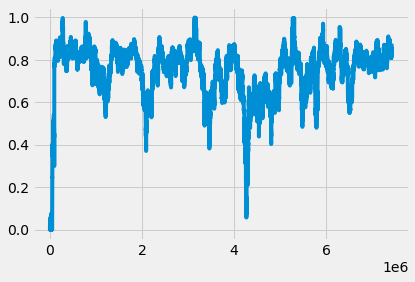

In [5]:
#getting data

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/5)),:]
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[200000:300000,:]
df_normal_grp_ID1[['Time']] = scaler.fit_transform(df_normal_grp_ID1[['Time']])
# df_normal_grp_ID1
plt.plot(df_normal_grp_ID1['Signal1'])

In [6]:
df_normal_grp_ID1['Signal1']

5          0.000000
12         0.000000
20         0.000000
27         0.000000
33         0.000000
             ...   
7417396    0.876350
7417403    0.876500
7417410    0.876641
7417417    0.876771
7417425    0.876901
Name: Signal1, Length: 1034952, dtype: float64

         Label      Time  Signal1_of_ID  Signal2_of_ID
1            0  0.000000       0.165060           0.25
7            0  0.000003       0.165400           0.50
16           0  0.000007       0.165821           0.75
22           0  0.000010       0.166301           1.00
29           0  0.000013       0.166662           0.00
...        ...       ...            ...            ...
2150020      0  0.999987       0.617179           0.75
2150028      0  0.999990       0.617330           1.00
2150035      0  0.999993       0.617460           0.00
2150043      0  0.999997       0.617570           0.25
2150048      0  1.000000       0.617650           0.50

[299997 rows x 4 columns]


Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

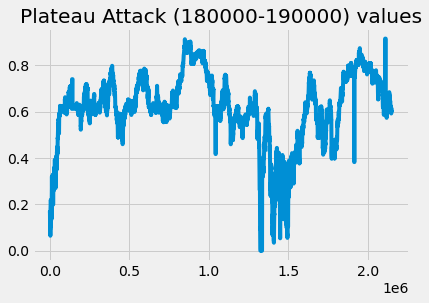

In [7]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

# plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
print(df_test_plat_ID1)
plt.plot(df_test_plat_ID1.iloc[:,2:3])
plt.title('Plateau Attack (180000-190000) values')

         Label      Time  Signal1_of_ID  Signal2_of_ID
5            0  0.000000       0.760648           0.00
13           0  0.000003       0.760718           0.25
20           0  0.000007       0.760758           0.50
26           0  0.000010       0.760798           0.75
35           0  0.000013       0.760848           1.00
...        ...       ...            ...            ...
2575768      0  0.999987       0.621343           0.75
2575775      0  0.999990       0.621384           1.00
2575783      0  0.999993       0.621403           0.00
2575790      0  0.999997       0.621414           0.25
2575796      0  1.000000       0.621414           0.50

[342827 rows x 4 columns]


Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

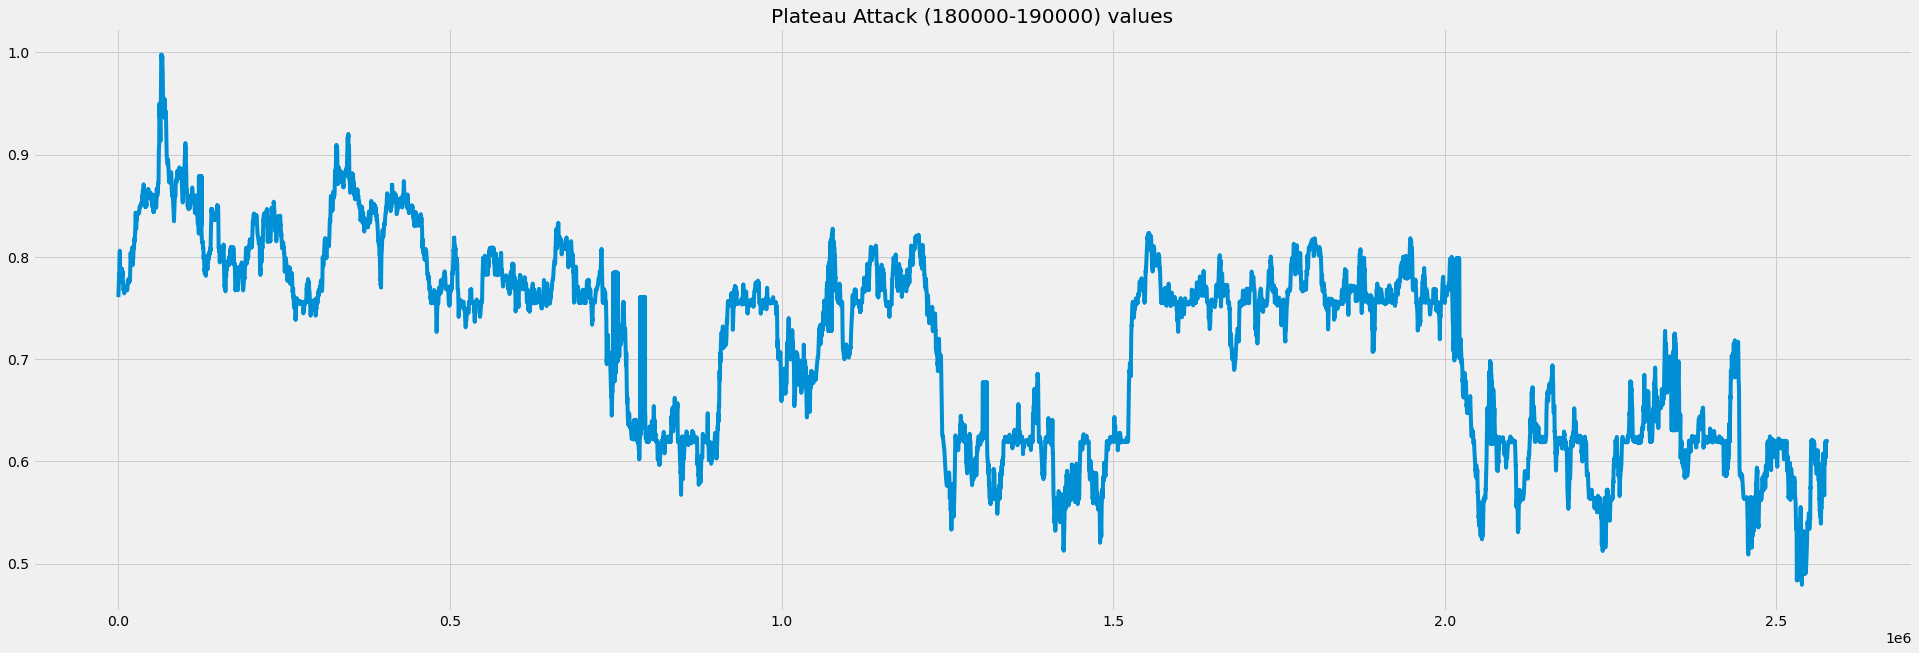

In [8]:
df_test_plat_ID1_fl = pd.read_csv('test_flooding.csv', delimiter=',')
df_test_plat_ID1_fl = df_test_plat_ID1_fl[df_test_plat_ID1_fl['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1_fl = df_test_plat_ID1_fl.drop(df_test_plat_ID1_fl[['ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1_fl[['Time']] = scaler.fit_transform(df_test_plat_ID1_fl[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

# plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
print(df_test_plat_ID1_fl)
plt.figure(figsize=(30,10))
plt.plot(df_test_plat_ID1_fl.iloc[:,2:3])
plt.title('Plateau Attack (180000-190000) values')

In [9]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_normal_grp_ID1[['Signal1']], df_normal_grp_ID1[['Signal1']], TIME_STEP)
X_test, Y_test = creatDataset(df_test_plat_ID1[['Signal1_of_ID']], df_test_plat_ID1[['Signal1_of_ID']], TIME_STEP)
X_test_fl, Y_test_fl = creatDataset(df_test_plat_ID1_fl[['Signal1_of_ID']], df_test_plat_ID1_fl[['Signal1_of_ID']], TIME_STEP)


### LSTM AUTOENCODER
#### Model Desgin

In [16]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(LSTM(128, activation = 'relu', 
input_shape =(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(RepeatVector(TIME_STEP))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
__________________________________________________

In [24]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(LSTM(128, activation = 'elu', 
input_shape =(X_train.shape[1],X_train.shape[2]), return_sequences = True))
model.add(LSTM(64, activation='elu', return_sequences=False))
model.add(RepeatVector(TIME_STEP))
model.add(LSTM(64, activation='elu', return_sequences=True))
model.add(LSTM(128, activation='elu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 247,937
Trainable params: 247,937
Non-trainable params: 0
__________________________________________________

#### Model Fitting

In [9]:
# fit model
model.fit(X_train, Y_train, epochs=5, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc_elu_mse")

NameError: name 'model' is not defined

In [ ]:
# fit model
model.fit(X_train, Y_train, epochs=10, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc_old")

NameError: name 'model' is not defined

#### Training loss, finding Threshold

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


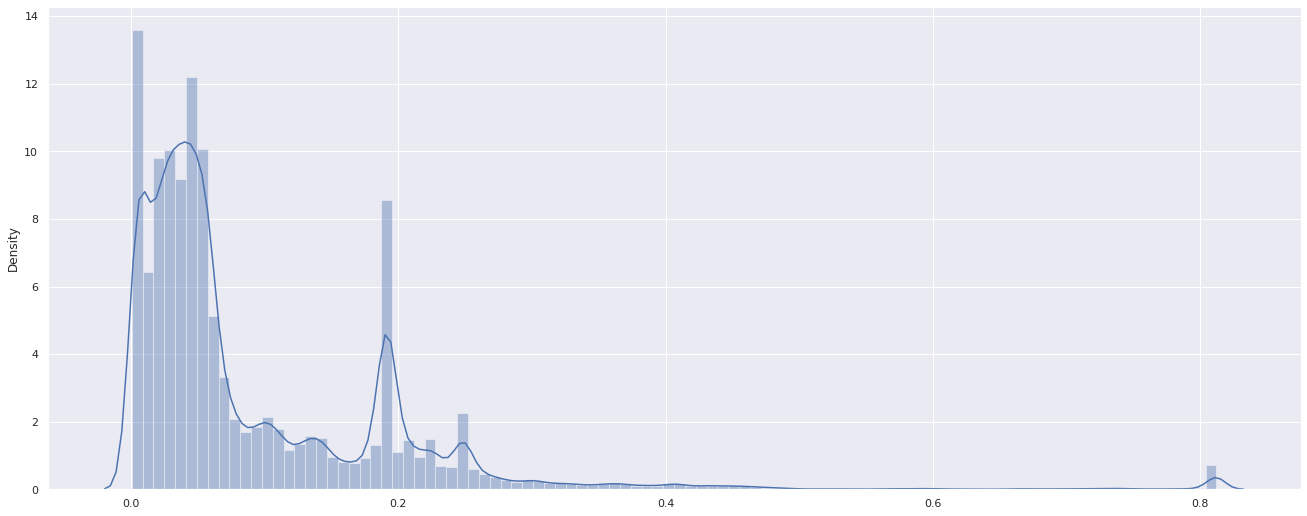

In [10]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc_elu_mse")
x_train_predict = reconstructed_model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_predict - X_train), axis=1)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.distplot(train_mae_loss,bins=100,kde=True)
plt.savefig('training_loss.png')


### Test Reconstruction errors

In [11]:

x_test_predict_pl = reconstructed_model.predict(X_test, verbose=0)
x_test_predict_fl = reconstructed_model.predict(X_test_fl, verbose=0)

test_mae_loss = np.mean(np.abs(x_test_predict_pl - X_test), axis=1)
test_mae_loss_fl = np.mean(np.abs(x_test_predict_fl - X_test_fl), axis=1)

print(test_mae_loss.shape)
print(test_mae_loss_fl.shape)




(299967, 1)
(342797, 1)


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

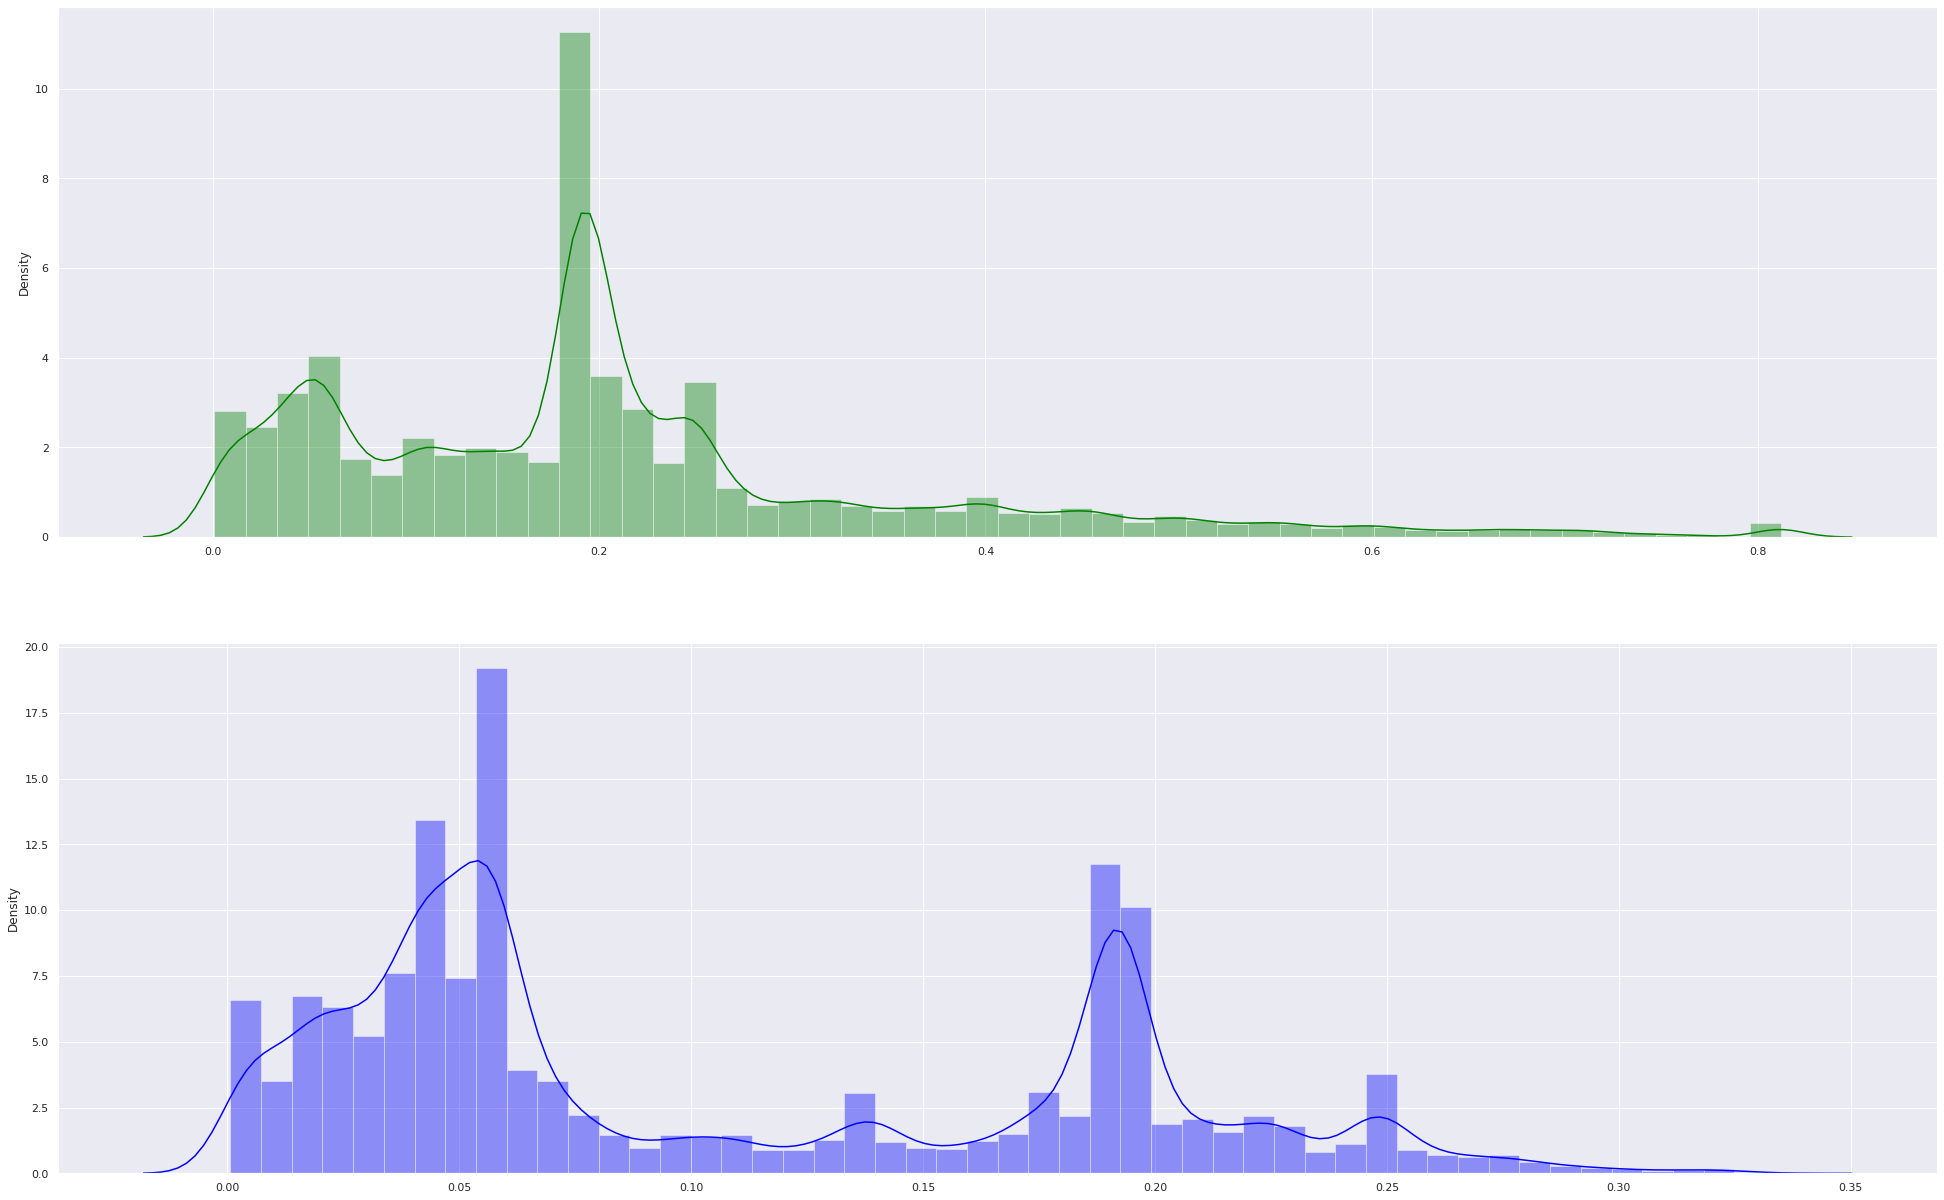

In [12]:
fig,axs = plt.subplots(2,1,squeeze=False, figsize=(30,20))

sns.distplot(test_mae_loss,bins=50,color = 'green',kde=True, ax = axs[0,0] )
sns.distplot(test_mae_loss_fl,bins=50,color = 'blue',kde=True, ax = axs[1,0] )

### Test Score Dataframe Creation and plotting


In [13]:
print(df_test_plat_ID1[TIME_STEP:].index.shape)
print(test_mae_loss.shape)

(299967,)
(299967, 1)


,loss,threshold_1,threshold_2,threshold_3,anomaly_1,anomaly_2,anomaly_3,Signal1,Label
220,0.049562,0.06,0.13,0.18,False,False,False,0.765453,0
229,0.049402,0.06,0.13,0.18,False,False,False,0.765723,0
235,0.049235,0.06,0.13,0.18,False,False,False,0.765953,0
242,0.049062,0.06,0.13,0.18,False,False,False,0.766163,0
250,0.048883,0.06,0.13,0.18,False,False,False,0.766334,0


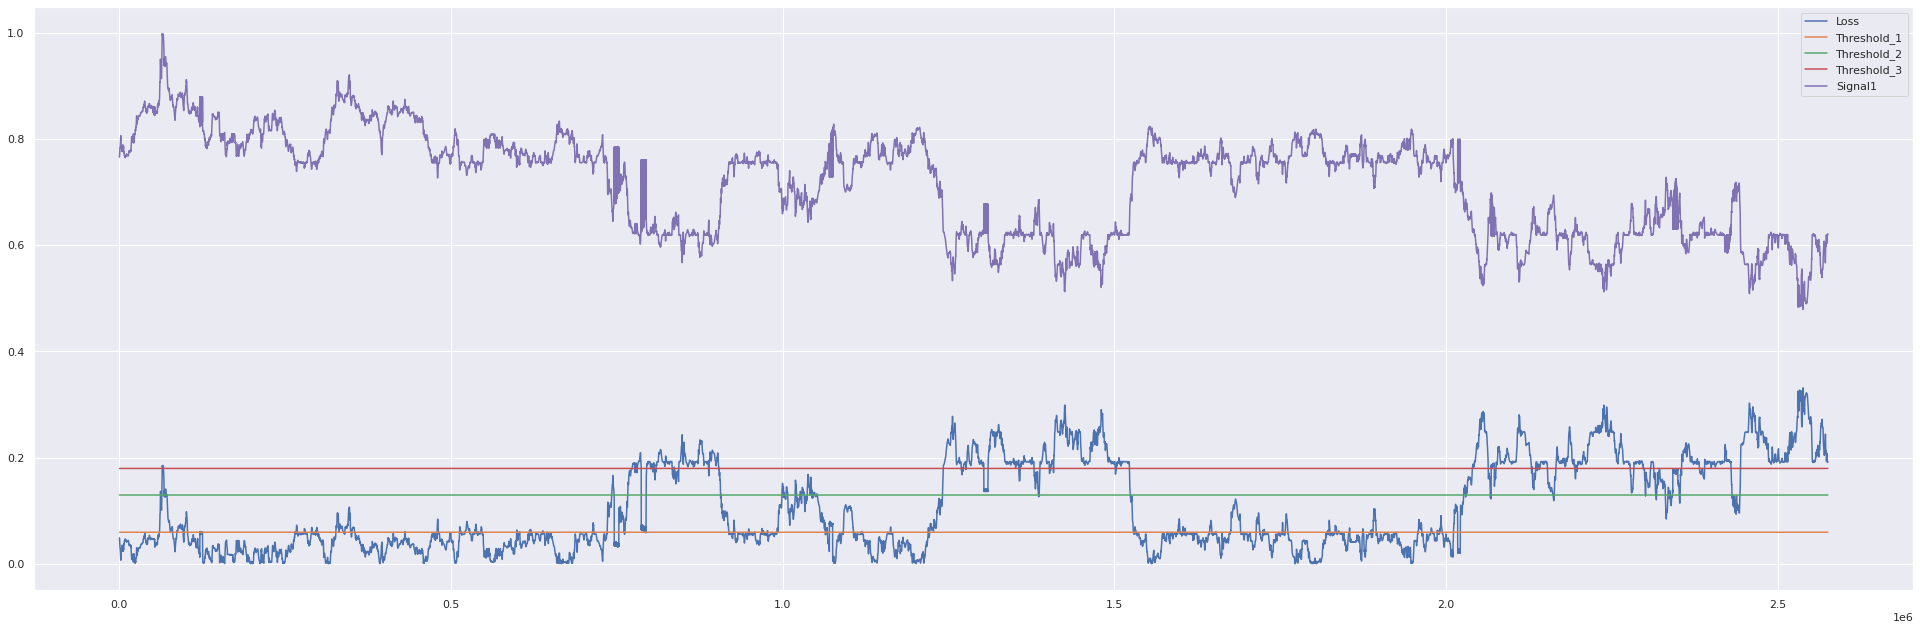

In [82]:
test_score_df_fl = pd.DataFrame(index=df_test_plat_ID1_fl[TIME_STEP:].index)
test_score_df_fl['loss'] = test_mae_loss_fl
test_score_df_fl['threshold_1'] = 0.06
test_score_df_fl['threshold_2'] = 0.13 #goldilocks
test_score_df_fl['threshold_3'] = 0.18

test_score_df_fl['anomaly_1'] = test_score_df_fl.loss > test_score_df_fl.threshold_1
test_score_df_fl['anomaly_2'] = test_score_df_fl.loss > test_score_df_fl.threshold_2
test_score_df_fl['anomaly_3'] = test_score_df_fl.loss > test_score_df_fl.threshold_3

test_score_df_fl['Signal1'] = df_test_plat_ID1_fl[TIME_STEP:].Signal1_of_ID
test_score_df_fl['Label'] = df_test_plat_ID1_fl[TIME_STEP:].Label
#plot the threshoold vs the actual loss values
plt.figure(figsize=(30,10))
plt.plot(test_score_df_fl.index, test_score_df_fl.loss, label='Loss')
plt.plot(test_score_df_fl.index, test_score_df_fl.threshold_1, label='Threshold_1')
plt.plot(test_score_df_fl.index, test_score_df_fl.threshold_2, label='Threshold_2')
plt.plot(test_score_df_fl.index, test_score_df_fl.threshold_3, label='Threshold_3')

plt.plot(test_score_df_fl.index,test_score_df_fl.Signal1, label='Signal1')
plt.legend()

test_score_df_fl.head()

,loss,threshold_1,threshold_2,threshold_3,anomaly_1,anomaly_2,anomaly_3,Signal1,Label
215,0.644193,0.05,0.23,0.32,True,True,True,0.167412,0
221,0.644115,0.05,0.23,0.32,True,True,True,0.167262,0
230,0.644053,0.05,0.23,0.32,True,True,True,0.167152,0
236,0.644008,0.05,0.23,0.32,True,True,True,0.167022,0
243,0.643984,0.05,0.23,0.32,True,True,True,0.166892,0


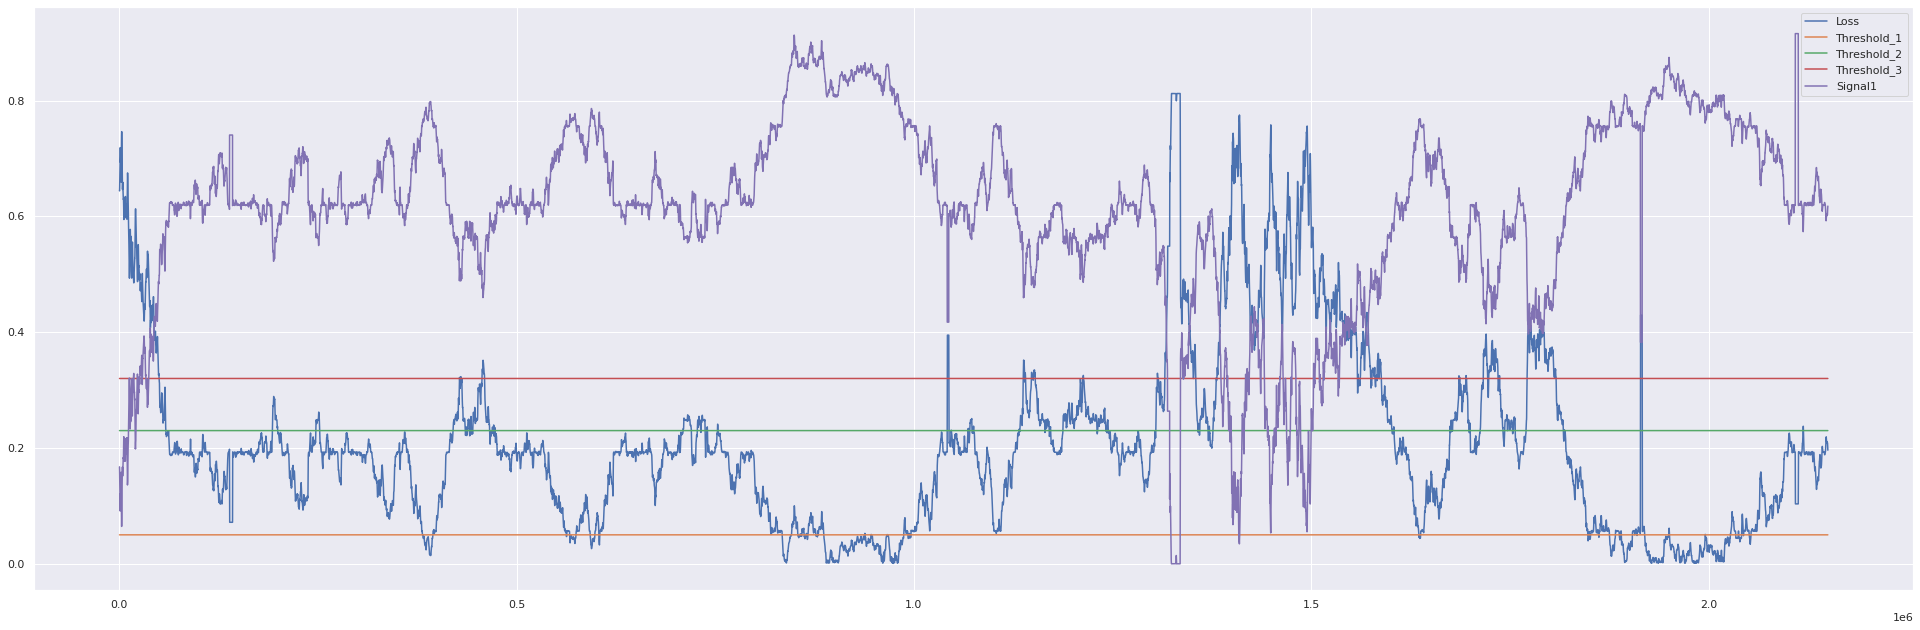

In [83]:
test_score_df = pd.DataFrame(index=df_test_plat_ID1[TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss

test_score_df['threshold_1'] = 0.05
test_score_df['threshold_2'] = 0.23 #goldilocks
test_score_df['threshold_3'] = 0.32

test_score_df['anomaly_1'] = test_score_df.loss > test_score_df.threshold_1
test_score_df['anomaly_2'] = test_score_df.loss > test_score_df.threshold_2
test_score_df['anomaly_3'] = test_score_df.loss > test_score_df.threshold_3

test_score_df['Signal1'] = df_test_plat_ID1[TIME_STEP:].Signal1_of_ID
test_score_df['Label'] = df_test_plat_ID1[TIME_STEP:].Label
#plot the threshoold vs the actual loss values
plt.figure(figsize=(30,10))
plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
plt.plot(test_score_df.index, test_score_df.threshold_1, label='Threshold_1')
plt.plot(test_score_df.index, test_score_df.threshold_2, label='Threshold_2')
plt.plot(test_score_df.index, test_score_df.threshold_3, label='Threshold_3')

plt.plot(test_score_df.index,test_score_df.Signal1, label='Signal1')
plt.legend()

test_score_df.head()

#### ROC Curves

In [84]:
def tpr_fpr_cal(anom,notAnom):

    TPs = anom[anom.Label == anom.anomaly_x]
    FPs = anom[anom.Label != anom.anomaly_x]
    FNs= notAnom[notAnom.Label != notAnom.anomaly_x]
    TNs= notAnom[notAnom.Label == notAnom.anomaly_x]

    tpr = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    fpr = FPs.iloc[:,0].shape[0]/ (FPs.iloc[:,0].shape[0] + TNs.iloc[:,0].shape[0])
    # print(tpr)
    # print(fpr)

    return tpr,fpr

In [85]:
def roc_from_scratch(test_df, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        test_df['anomaly_x'] = test_df.loss > (i / partitions)
        anomalies = test_df[test_df.loss > (i / partitions)]
        notAnomalies =  test_df[test_df.loss <= (i / partitions)]
        
        # print(notAnomalies)
        tpr, fpr = tpr_fpr_cal(anomalies, notAnomalies)
        if(0.37 > tpr < 0.38):
            print(i / partitions)
            print("-----")

        roc = np.append(roc, [tpr, fpr])
        
    roc_res = roc.reshape(-1, 2)
    sort_indices_fpr = (roc_res[:,1]).argsort()
    sorted_roc = roc_res[sort_indices_fpr]
    print(roc_res)
    # Calculate the AUC score using the trapezoidal rule
    auc_score = np.trapz(sorted_roc[:, 0], x=sorted_roc[:, 1])
    # auc_score = 0

        
    return roc_res, auc_score

In [86]:
def metric_cal(df):

    TPs= df[(df.anomaly_x == 1)&(df.Label == 1)]
    FPs= df[(df.anomaly_x == 1)&(df.Label == 0)]
    FNs= df[(df.anomaly_x == 0)&(df.Label == 1)]
    TNs= df[(df.anomaly_x == 0)&(df.Label == 0)]

    
    TPs_div = TPs.iloc[:,0].shape[0]
    TNs_div = TNs.iloc[:,0].shape[0]
    FPs_div = FPs.iloc[:,0].shape[0]
    FNs_div = FNs.iloc[:,0].shape[0]

    if (TPs_div!=0 and TNs_div!=0  and FPs_div!=0  and FNs_div!=0 ):

        recall = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
        precision = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0])
        accuracy = (TPs.iloc[:,0].shape[0] + TNs.iloc[:,0].shape[0]) / (TPs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0] +TNs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
        specificity = TNs.iloc[:,0].shape[0] / (TNs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0])
        
        if(recall!=0 and precision!=0):
            f1 = 2*((precision * recall )/(precision + recall ))
    else:
        print("TPs = " + str(TPs_div))
        print("FPs = " + str(FPs_div))
        print("TNs = " + str(TNs_div))
        print("FNs = " + str(FNs_div))


        f1 = 0
        recall = 0
        precision = 0
        accuracy = 0
        specificity = 0
        # f1 = 0

    

    return recall, precision, accuracy, specificity, f1, TPs_div, FPs_div, TNs_div, FNs_div

In [87]:
def metric_graph(test_df, partitions=100):
    thr = np.array([])
    tps = np.array([])
    fps = np.array([])
    tns = np.array([])
    fns = np.array([])
    metric_st = np.array([])

    for i in range(partitions + 1):
        test_df['anomaly_x'] = test_df.loss > (i / partitions)
            
        metric = metric_cal(test_df)
        
        if (not(metric[0]!=0 and metric[1]!=0  and metric[2]!=0  and metric[3]!=0 )):
            print("Threshold = " + str(i / partitions))

        tps = np.append(tps, metric[5])
        fps = np.append(fps, metric[6])
        tns = np.append(tns, metric[7])
        fns = np.append(fns, metric[8])
        thr = np.append(thr, (i / partitions))
        metric_st = np.append(metric_st, [metric[0],metric[1],metric[2],metric[3],metric[4]])
        
    met_res = metric_st.reshape(-1, 5)

    # print(roc_res)
    return met_res, tps, fps, tns, fns, thr

        
    # return roc_res, auc_score

TPs = 48961
FPs = 251006
TNs = 0
FNs = 0
Threshold = 0.0
TPs = 0
FPs = 2395
TNs = 248611
FNs = 48961
Threshold = 0.73
TPs = 0
FPs = 2220
TNs = 248786
FNs = 48961
Threshold = 0.74
TPs = 0
FPs = 1955
TNs = 249051
FNs = 48961
Threshold = 0.75
TPs = 0
FPs = 1810
TNs = 249196
FNs = 48961
Threshold = 0.76
TPs = 0
FPs = 1698
TNs = 249308
FNs = 48961
Threshold = 0.77
TPs = 0
FPs = 1601
TNs = 249405
FNs = 48961
Threshold = 0.78
TPs = 0
FPs = 1584
TNs = 249422
FNs = 48961
Threshold = 0.79
TPs = 0
FPs = 1552
TNs = 249454
FNs = 48961
Threshold = 0.8
TPs = 0
FPs = 1437
TNs = 249569
FNs = 48961
Threshold = 0.81
TPs = 0
FPs = 0
TNs = 251006
FNs = 48961
Threshold = 0.82
TPs = 0
FPs = 0
TNs = 251006
FNs = 48961
Threshold = 0.83
TPs = 0
FPs = 0
TNs = 251006
FNs = 48961
Threshold = 0.84
TPs = 0
FPs = 0
TNs = 251006
FNs = 48961
Threshold = 0.85
TPs = 0
FPs = 0
TNs = 251006
FNs = 48961
Threshold = 0.86
TPs = 0
FPs = 0
TNs = 251006
FNs = 48961
Threshold = 0.87
TPs = 0
FPs = 0
TNs = 251006
FNs = 48961
Thresh

Text(0, 0.5, 'Amplitude')

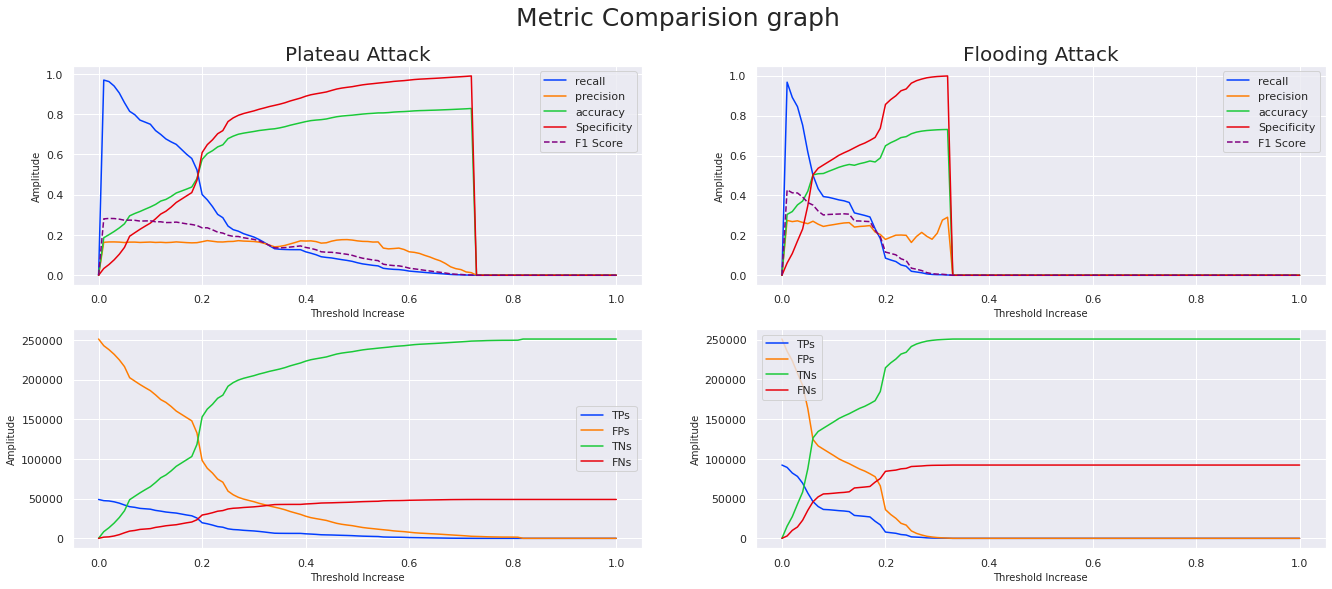

In [88]:
met_pl=metric_graph(test_score_df)
print("===================")
met_fl=metric_graph(test_score_df_fl)
metrics_pl = met_pl[0]
metrics_fl = met_fl[0]
# print(metrics_pl)
print(met_fl[5])
print(metrics_fl[:,0])
print(metrics_fl[:,1])
print(metrics_fl[:,2])
print(metrics_fl[:,3])


# print(met_pl[1])
# print(met_pl[2])


fig,axs = plt.subplots(2,2)

fig.suptitle('Metric Comparision graph',fontsize=25)

pallete = sns.color_palette('bright')


axs[0,0].plot(met_pl[5],metrics_pl[:,0],color=pallete[0], label = 'recall')
axs[0,0].plot(met_pl[5],metrics_pl[:,1],color=pallete[1], label = 'precision')
axs[0,0].plot(met_pl[5],metrics_pl[:,2],color=pallete[2], label = 'accuracy')
axs[0,0].plot(met_pl[5],metrics_pl[:,3],color=pallete[3], label = 'Specificity')
axs[0,0].plot(met_pl[5],metrics_pl[:,4], "--",color="purple", label = 'F1 Score')


axs[0,0].legend()
axs[0,0].set_xlabel('Threshold Increase',fontsize=10)
axs[0,0].set_ylabel('Amplitude',fontsize=10)
axs[0,0].set_title('Plateau Attack',fontsize=20)

axs[0,1].plot(met_fl[5],metrics_fl[:,0],color=pallete[0], label = 'recall')
axs[0,1].plot(met_fl[5],metrics_fl[:,1],color=pallete[1], label = 'precision')
axs[0,1].plot(met_fl[5],metrics_fl[:,2],color=pallete[2], label = 'accuracy')
axs[0,1].plot(met_fl[5],metrics_fl[:,3],color=pallete[3], label = 'Specificity')
axs[0,1].plot(met_fl[5],metrics_fl[:,4], "--",color="purple", label = 'F1 Score')

axs[0,1].legend()
axs[0,1].set_title('Flooding Attack',fontsize=20)
axs[0,1].set_xlabel('Threshold Increase',fontsize=10)
axs[0,1].set_ylabel('Amplitude',fontsize=10)

axs[1,0].plot(met_pl[5],met_pl[1],color=pallete[0], label = 'TPs')
axs[1,0].plot(met_pl[5],met_pl[2],color=pallete[1], label = 'FPs')
axs[1,0].plot(met_pl[5],met_pl[3],color=pallete[2], label = 'TNs')
axs[1,0].plot(met_pl[5],met_pl[4],color=pallete[3], label = 'FNs')
axs[1,0].legend()
axs[1,0].set_xlabel('Threshold Increase',fontsize=10)
axs[1,0].set_ylabel('Amplitude',fontsize=10)

axs[1,1].plot(met_fl[5],met_fl[1],color=pallete[0], label = 'TPs')
axs[1,1].plot(met_fl[5],met_fl[2],color=pallete[1], label = 'FPs')
axs[1,1].plot(met_fl[5],met_fl[3],color=pallete[2], label = 'TNs')
axs[1,1].plot(met_fl[5],met_fl[4],color=pallete[3], label = 'FNs')
axs[1,1].legend()
axs[1,1].set_xlabel('Threshold Increase',fontsize=10)
axs[1,1].set_ylabel('Amplitude',fontsize=10)



0.22
-----
0.23
-----
0.24
-----
0.25
-----
0.26
-----
0.27
-----
0.28
-----
0.29
-----
0.3
-----
0.31
-----
0.32
-----
0.33
-----
0.34
-----
0.35
-----
0.36
-----
0.37
-----
0.38
-----
0.39
-----
0.4
-----
0.41
-----
0.42
-----
0.43
-----
0.44
-----
0.45
-----
0.46
-----
0.47
-----
0.48
-----
0.49
-----
0.5
-----
0.51
-----
0.52
-----
0.53
-----
0.54
-----
0.55
-----
0.56
-----
0.57
-----
0.58
-----
0.59
-----
0.6
-----
0.61
-----
0.62
-----
0.63
-----
0.64
-----
0.65
-----
0.66
-----
0.67
-----
0.68
-----
0.69
-----
0.7
-----
0.71
-----
0.72
-----
0.73
-----
0.74
-----
0.75
-----
0.76
-----
0.77
-----
0.78
-----
0.79
-----
0.8
-----
0.81
-----
0.82
-----
0.83
-----
0.84
-----
0.85
-----
0.86
-----
0.87
-----
0.88
-----
0.89
-----
0.9
-----
0.91
-----
0.92
-----
0.93
-----
0.94
-----
0.95
-----
0.96
-----
0.97
-----
0.98
-----
0.99
-----
1.0
-----
[[1.00000000e+00 1.00000000e+00]
 [9.69261249e-01 9.66570520e-01]
 [9.61826760e-01 9.46845892e-01]
 [9.39727538e-01 9.23531708e-01]
 [9.051

Text(0, 0.5, 'True Positive Rate')

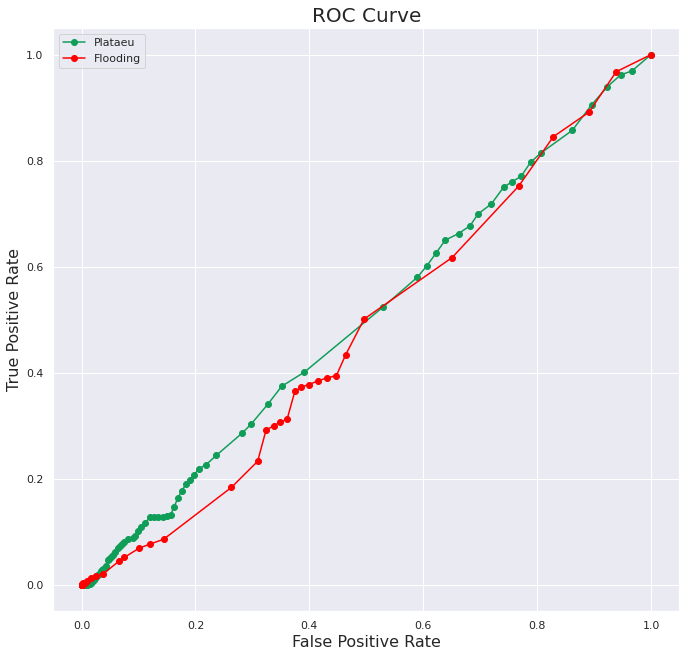

In [89]:
roc, auc = roc_from_scratch(test_score_df)
roc_fl, auc_fl = roc_from_scratch(test_score_df_fl)

print("AUC Plataeu = " + str(auc))
print("AUC Flooding = " + str(auc_fl))

plt.figure(figsize=(10,10))
plt.plot(roc[:,1],roc[:,0],color='#0F9D58', marker='o', label = 'Plataeu')
plt.plot(roc_fl[:,1],roc_fl[:,0],color='red', marker='o', label = 'Flooding')
plt.legend()
plt.title('ROC Curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=16)
plt.ylabel('True Positive Rate',fontsize=16)


#### Confusion Matrix Creation

In [22]:
def conf_matrix_cal_1(df ,mode): #for threshold 1

    TPs =  df[(df.anomaly_1 == 1)&(df.Label == 1)]
    FPs = df[(df.anomaly_1 == 1)&(df.Label == 0)]
    FNs= df[(df.anomaly_1 == 0)&(df.Label == 1)]
    TNs= df[(df.anomaly_1 == 0)&(df.Label == 0)]

    if(mode == 'num'):
        return TPs.iloc[:,0].shape[0],FPs.iloc[:,0].shape[0],FNs.iloc[:,0].shape[0],TNs.iloc[:,0].shape[0]
    else:
        return TPs,FPs,FNs,TNs

In [23]:
def conf_matrix_cal_2(df, mode): #for threshold 2

    TPs =  df[(df.anomaly_2 == 1)&(df.Label == 1)]
    FPs = df[(df.anomaly_2 == 1)&(df.Label == 0)]
    FNs= df[(df.anomaly_2 == 0)&(df.Label == 1)]
    TNs= df[(df.anomaly_2 == 0)&(df.Label == 0)]

    if(mode == 'num'):
        return TPs.iloc[:,0].shape[0],FPs.iloc[:,0].shape[0],FNs.iloc[:,0].shape[0],TNs.iloc[:,0].shape[0]
    else:
        return TPs,FPs,FNs,TNs

In [24]:
def f1_score_1(df):

    TPs =  df[(df.anomaly_1 == 1)&(df.Label == 1)]
    FPs = df[(df.anomaly_1 == 1)&(df.Label == 0)]
    FNs= df[(df.anomaly_1 == 0)&(df.Label == 1)]
    TNs= df[(df.anomaly_1 == 0)&(df.Label == 0)]

    recall = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    precision = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0])
    accuracy = (TPs.iloc[:,0].shape[0] + TNs.iloc[:,0].shape[0]) / (TPs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0] +TNs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    specificity = TNs.iloc[:,0].shape[0] / (TNs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0])

    f1 = 2*((precision * recall )/(precision + recall))
    f1 = f1*100 #in percent

    return f1, recall, precision, accuracy, specificity

In [25]:
def f1_score_2(df):

    TPs =  df[(df.anomaly_2 == 1)&(df.Label == 1)]
    FPs = df[(df.anomaly_2 == 1)&(df.Label == 0)]
    FNs= df[(df.anomaly_2 == 0)&(df.Label == 1)]
    TNs= df[(df.anomaly_2 == 0)&(df.Label == 0)]

    recall = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    precision = TPs.iloc[:,0].shape[0] / (TPs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0])
    accuracy = (TPs.iloc[:,0].shape[0] + TNs.iloc[:,0].shape[0]) / (TPs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0] +TNs.iloc[:,0].shape[0] + FNs.iloc[:,0].shape[0])
    specificity = TNs.iloc[:,0].shape[0] / (TNs.iloc[:,0].shape[0] + FPs.iloc[:,0].shape[0])
    f1 = 2*((precision * recall )/(precision + recall))
    f1 = f1*100 #in percent
    

    return f1, recall, precision, accuracy, specificity


In [26]:
def create_attack_dataframe(array1, array2):
    categories = ["Plateau Attack", "Flooding Attack"]
    columns = ["f1", "recall", "precision", "accuracy", "Specificity"]
    df = pd.DataFrame(index=range(len(array1)), columns=pd.MultiIndex.from_product([categories, columns]))
    for i in range(len(array1)):
        df.loc[i] = [
            array1[i][0], array1[i][1], array1[i][2], array1[i][3], array1[i][4],
            array2[i][0], array2[i][1], array2[i][2], array2[i][3], array2[i][4],
        ]
    df.index.name = "Thresholds"
    return df

In [27]:
anomalies_1 = test_score_df[test_score_df.anomaly_1 == True] #for threshold 1
anomalies_2 = test_score_df[test_score_df.anomaly_2 == True] #for threshold 2


stats = np.empty([2,4],dtype='int')
metric = np.empty([2,5])


stats[0] = conf_matrix_cal_1(test_score_df,'num')
stats[1] = conf_matrix_cal_2(test_score_df,'num')

stats_df_1 = conf_matrix_cal_1(test_score_df,'df')
stats_df_2 = conf_matrix_cal_2(test_score_df,'df')

metric[0] = f1_score_1(test_score_df) #for threshold 1
metric[1] = f1_score_2(test_score_df) #for threshold 2


In [28]:
anomalies_1_fl = test_score_df_fl[test_score_df_fl.anomaly_1 == True] #for threshold 1
anomalies_2_fl = test_score_df_fl[test_score_df_fl.anomaly_2 == True] #for threshold 2


stats_fl = np.empty([2,4],dtype='int')
metric_fl = np.empty([2,5])


stats_fl[0] = conf_matrix_cal_1(test_score_df_fl,'num')
stats_fl[1] = conf_matrix_cal_2(test_score_df_fl,'num')

stats_df_1 = conf_matrix_cal_1(test_score_df_fl,'df')
stats_df_2 = conf_matrix_cal_2(test_score_df_fl,'df')

metric_fl[0] = f1_score_1(test_score_df_fl) #for threshold 1
metric_fl[1] = f1_score_2(test_score_df_fl) #for threshold 2



In [29]:
df_all_attacks = create_attack_dataframe(metric,metric_fl)
df_all_attacks.head()

Plateau Attack                                            \
                       f1    recall precision  accuracy Specificity   
Thresholds                                                            
0                 19.8754  0.244358  0.167495  0.678425    0.763093   
1                 23.5437  0.400829  0.166667  0.575083    0.609073   

           Flooding Attack                                             
                        f1     recall precision  accuracy Specificity  
Thresholds                                                             
0                  3.56051  0.0199651  0.164359  0.709227    0.962675  
1                  11.6086  0.0857521  0.179626  0.648912     0.85599

#### Total anomalies Plotted: Predicted VS Test 

[[ 11964  59465  36997 191541]
 [ 19625  98125  29336 152881]]


Text(0.73, 0.95, 'Threshold 2')

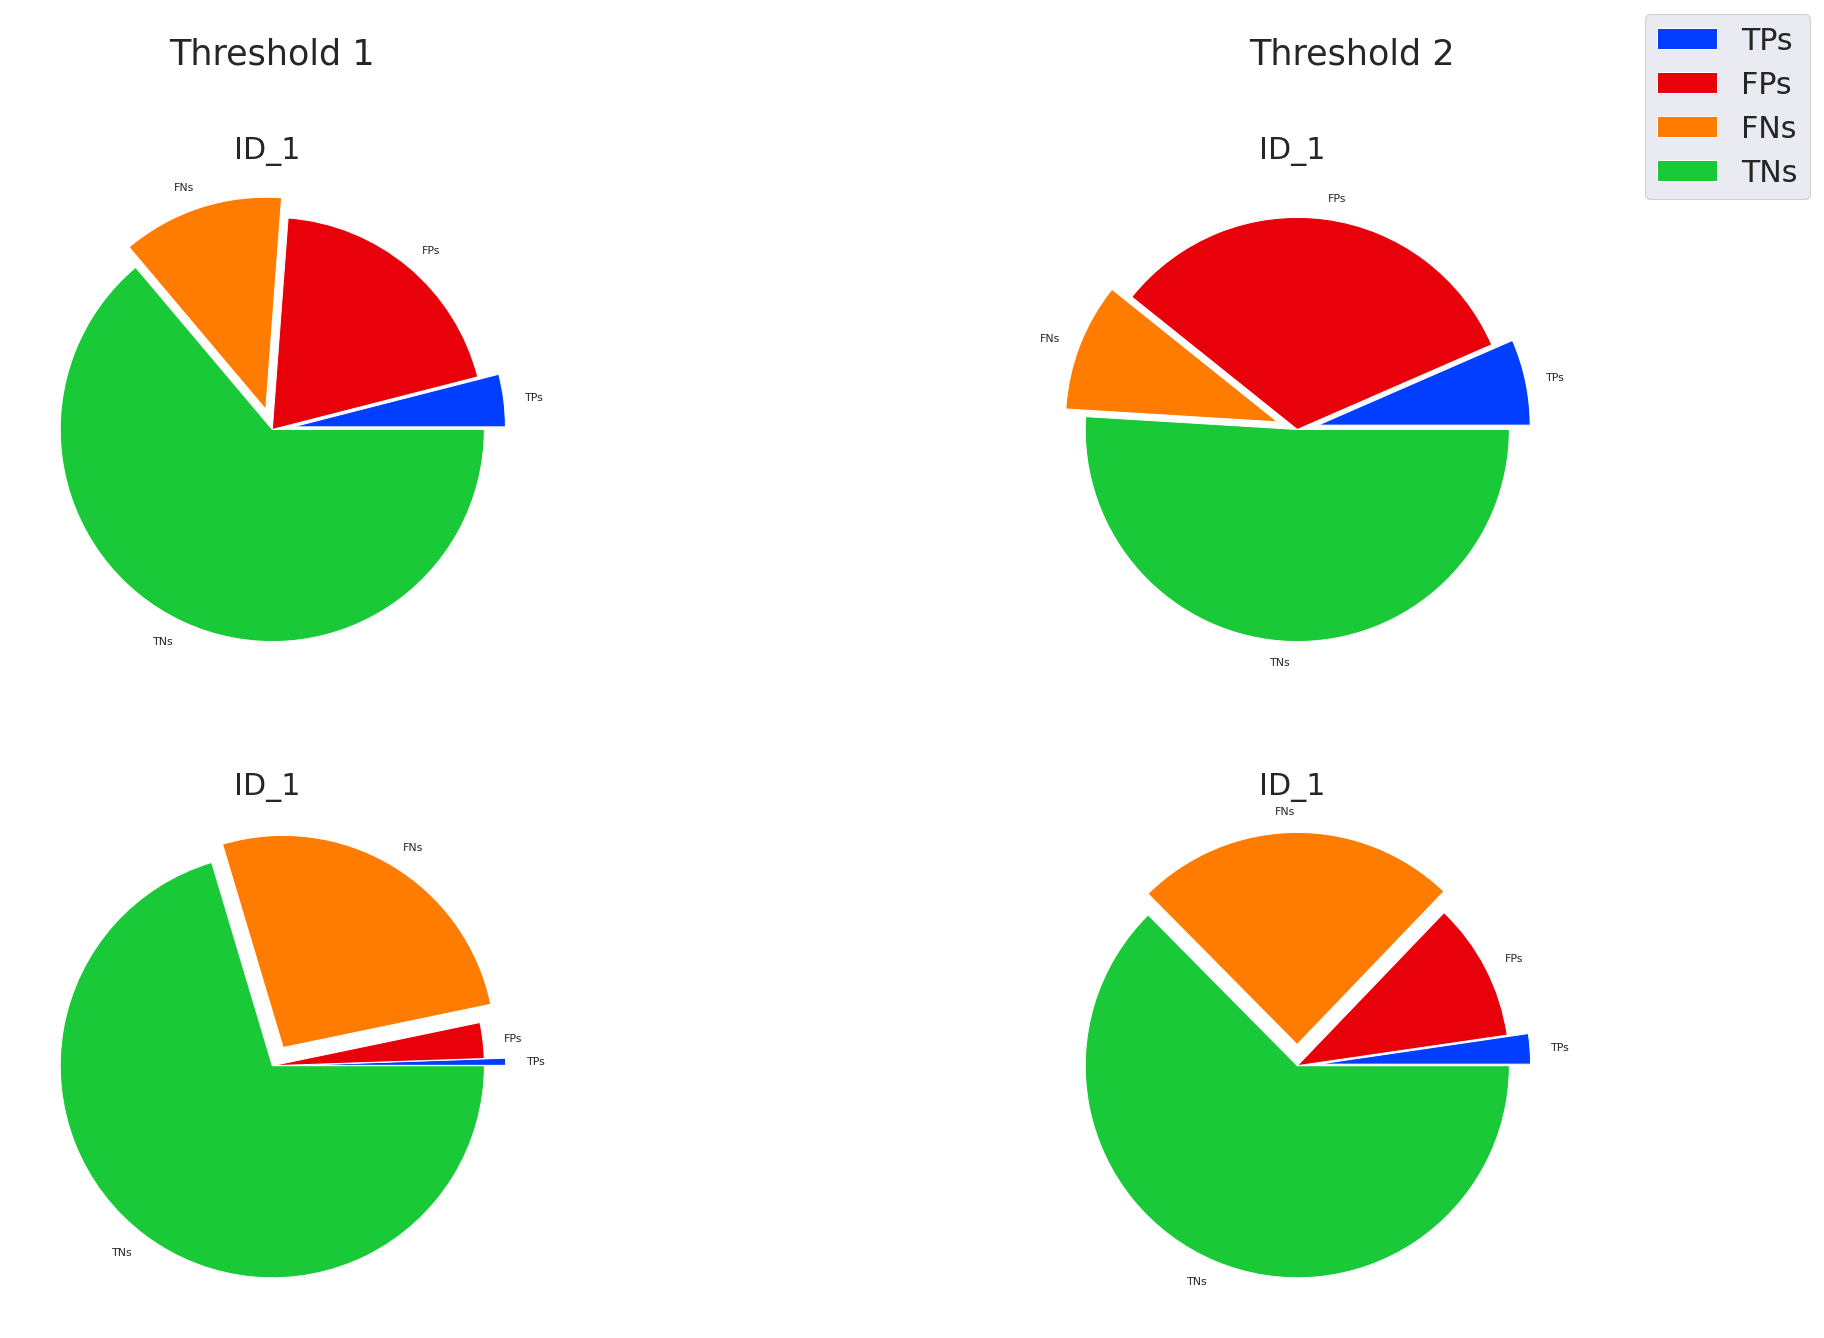

In [30]:
print(stats)
pallete = sns.color_palette('bright')
colors = [pallete[0],pallete[3],pallete[1],pallete[2]]
fig,axs = plt.subplots(2,2,squeeze=False, figsize=(30,20))
fig.set_facecolor('white')
labels = ['TPs', 'FPs', 'FNs', 'TNs']
explode = (0.1, 0, 0.1, 0)

# axs[0].set_title('Threshold 1',fontsize=18)

axs[0,0].set_title('ID_1 ',fontsize=30)
axs[0,0].pie(
stats[0],
labels = labels,
colors = colors,
explode = explode,
 )

axs[0,1].set_title('ID_1 ',fontsize=30)
axs[0,1].pie(
stats[1],
labels = labels,
colors = colors,
explode = explode,
 )
fig.legend(labels=labels, fontsize = 30)

axs[1,0].set_title('ID_1 ',fontsize=30)
axs[1,0].pie(
stats_fl[0],
labels = labels,
colors = colors,
explode = explode,
 )

axs[1,1].set_title('ID_1 ',fontsize=30)
axs[1,1].pie(
stats_fl[1],
labels = labels,
colors = colors,
explode = explode,
 )
fig.legend(labels=labels, fontsize = 30)

plt.figtext(0.23,0.95,"Threshold 1", fontsize = 35)
plt.figtext(0.73,0.95,"Threshold 2", fontsize = 35)

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

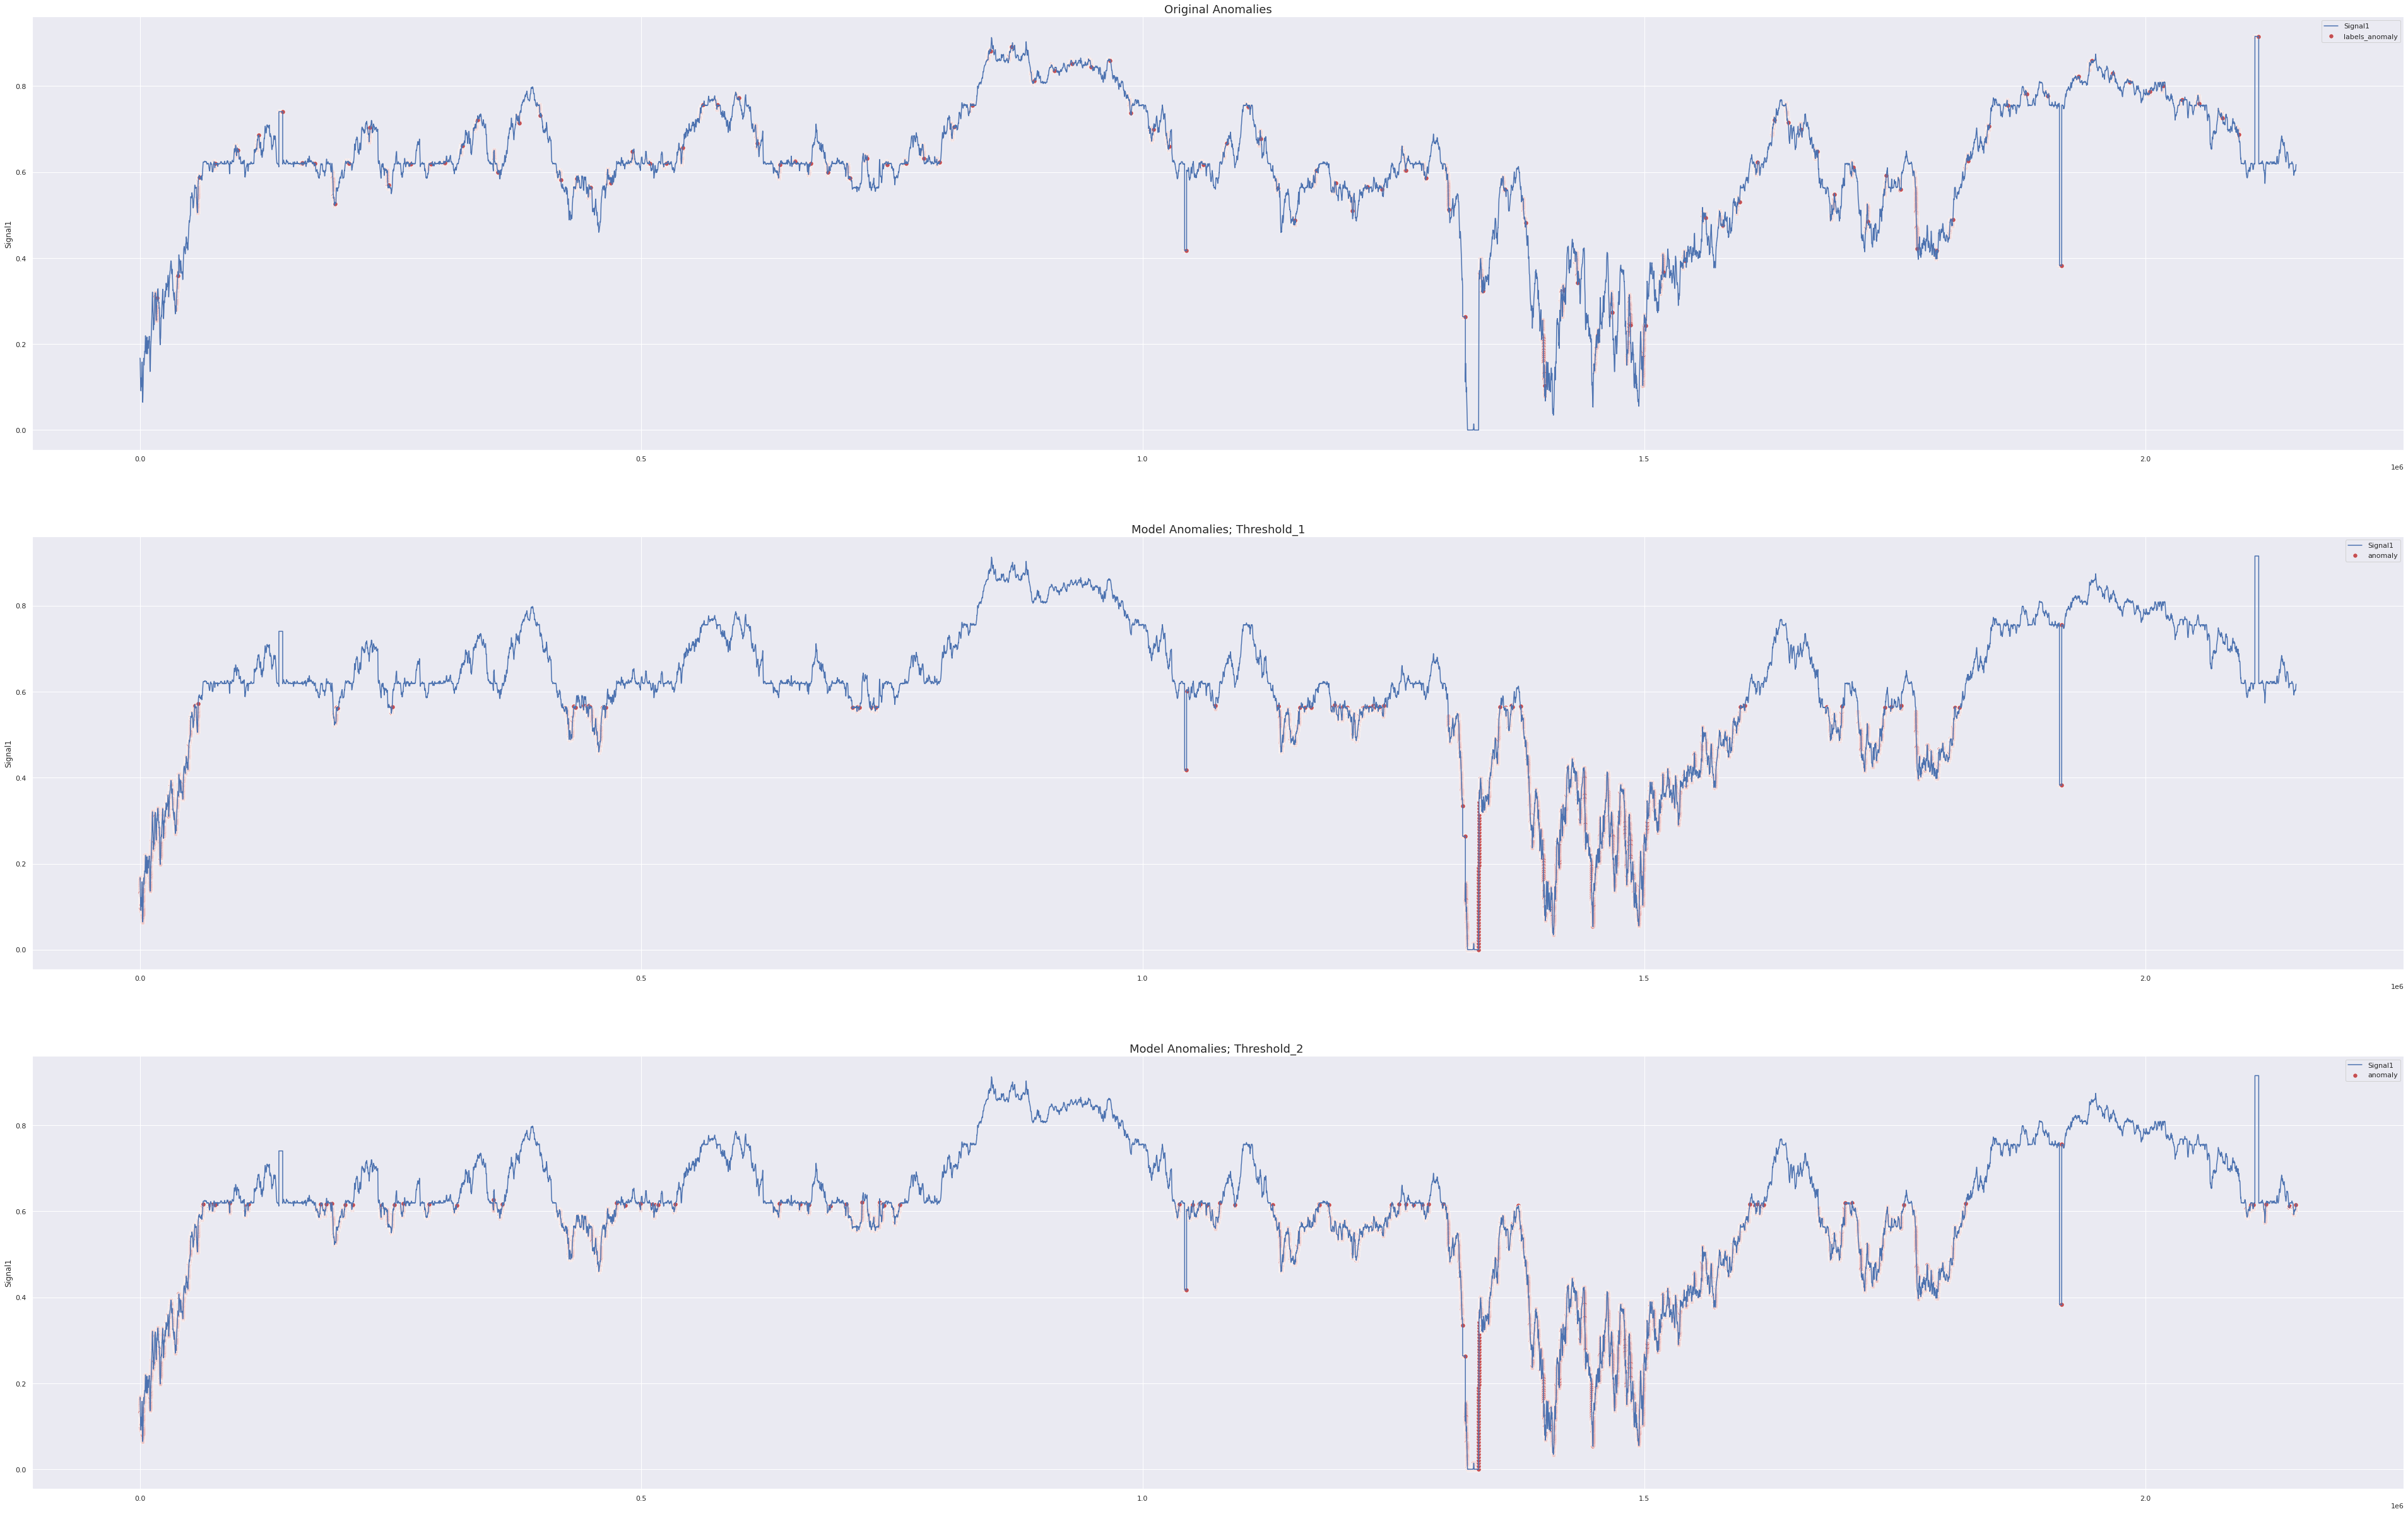

In [31]:
fig,axs = plt.subplots(3,1,squeeze=False, figsize=(60,40))

axs[0,0].set_title('Original Anomalies',fontsize=18)
axs[0,0].plot(
 test_score_df.index, 
 test_score_df.Signal1, 
  label='Signal1'
)

test_labels = test_score_df[test_score_df.Label == True]

sns.scatterplot(
  test_labels.index,
  test_labels.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='labels_anomaly',
  ax = axs[0,0]
)

axs[1,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[1,0].plot(
  test_score_df.index, 
  test_score_df.Signal1, 
  label='Signal1'
  )

sns.scatterplot(
  anomalies_1.index,
  anomalies_1.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[1,0]
)
axs[2,0].set_title('Model Anomalies; Threshold_2 ',fontsize=18)

axs[2,0].plot(
  test_score_df.index, 
  test_score_df.Signal1, 
  label='Signal1'
  )

sns.scatterplot(
  anomalies_2.index,
  anomalies_2.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly',
  ax = axs[2,0]
)

plt.legend();

#### TPs and FPs VS TNs and FNs

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
No handles with labels found to put in legend.
/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keywor

<AxesSubplot:ylabel='Signal1'>

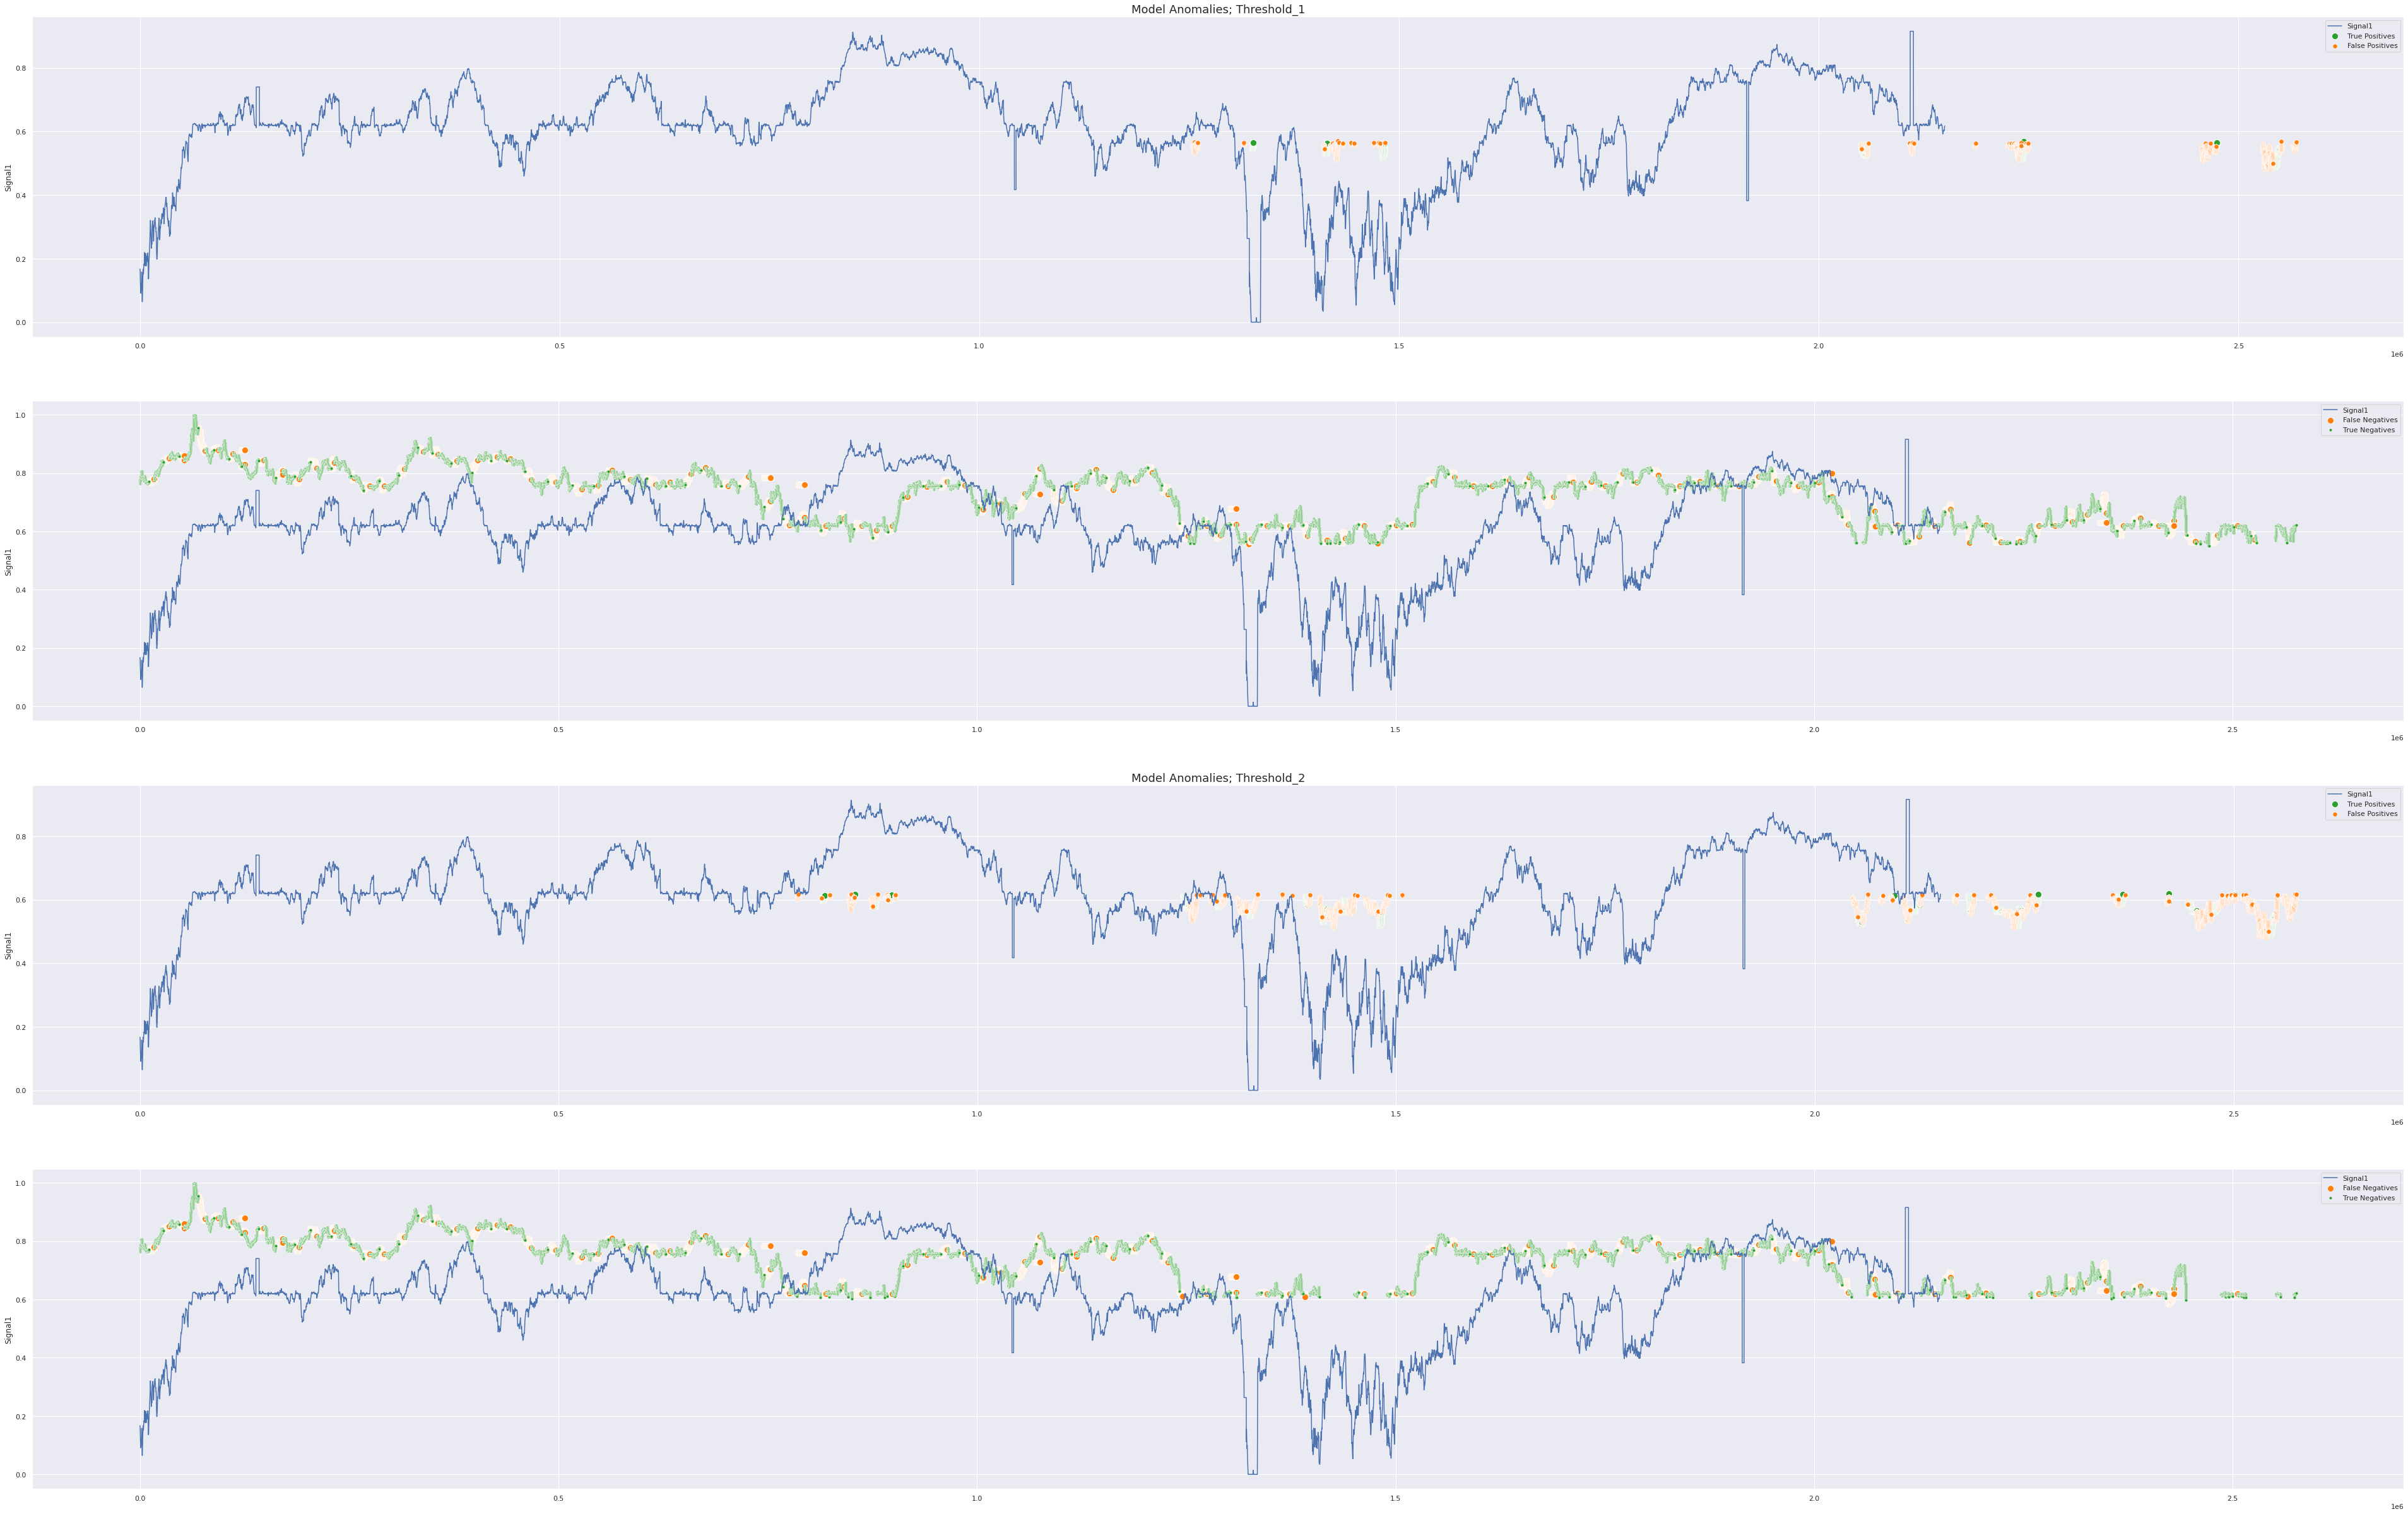

In [32]:
# plt.figure(figsize=(30,10))
fig,axs = plt.subplots(4,1,squeeze=False, figsize=(60,40))

# Threshold 1
axs[0,0].set_title('Model Anomalies; Threshold_1',fontsize=18)

axs[0,0].plot(
test_score_df.index, 
test_score_df.Signal1,
label='Signal1'
)

sns.scatterplot(
  stats_df_1[0].index, 
  stats_df_1[0].Signal1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[0,0]
)

sns.scatterplot(
  stats_df_1[1].index, 
  stats_df_1[1].Signal1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[0,0]
)
plt.legend()
axs[1,0].plot(
test_score_df.index, 
test_score_df.Signal1, 
  label='Signal1'
)

sns.scatterplot(
  stats_df_1[2].index, 
  stats_df_1[2].Signal1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[1,0]
)
sns.scatterplot(
  stats_df_1[3].index, 
  stats_df_1[3].Signal1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[1,0]
)


# Threshold 2
axs[2,0].set_title('Model Anomalies; Threshold_2',fontsize=18)


axs[2,0].plot(
test_score_df.index, 
test_score_df.Signal1,
label='Signal1'
)

sns.scatterplot(
  stats_df_2[0].index, 
  stats_df_2[0].Signal1,
  color=sns.color_palette("tab10")[2],
  s=100,
  markers='o',
  label='True Positives',
  ax = axs[2,0]
)

sns.scatterplot(
  stats_df_2[1].index, 
  stats_df_2[1].Signal1,
  color=sns.color_palette("tab10")[1],
  s=52,
  label='False Positives',
  ax = axs[2,0]
)
plt.legend()
axs[3,0].plot(
test_score_df.index, 
test_score_df.Signal1, 
  label='Signal1'
)

sns.scatterplot(
  stats_df_2[2].index, 
  stats_df_2[2].Signal1,
  color=sns.color_palette("tab10")[1],
  s=100,
  markers='o',
  label='False Negatives',
  ax = axs[3,0]
)
sns.scatterplot(
  stats_df_2[3].index, 
  stats_df_2[3].Signal1,
  color=sns.color_palette("tab10")[2],
  s=20,
  markers='o',
  label='True Negatives',
  ax = axs[3,0]
)

